In [1]:
import os
from typing import  Optional
import cv2
import supervision as sv
import torch
import numpy as np
from copy import deepcopy

from PIL import Image
from IPython.display import display

from sam3.model_builder import build_sam3_image_model
from sam3.model.sam3_image_processor import Sam3Processor

torch.cuda.is_available()

True

In [2]:
model = build_sam3_image_model()
processor = Sam3Processor(model, confidence_threshold=0.3)

In [3]:
COLOR = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])


def annotate(image: Image.Image, detections: sv.Detections, label: Optional[str] = None) -> Image.Image:
    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)

    mask_annotator = sv.MaskAnnotator(
        color=COLOR,
        color_lookup=sv.ColorLookup.INDEX,
        opacity=0.6
    )
    box_annotator = sv.BoxAnnotator(
        color=COLOR,
        color_lookup=sv.ColorLookup.INDEX,
        thickness=1
    )
    label_annotator = sv.LabelAnnotator(
        color=COLOR,
        color_lookup=sv.ColorLookup.INDEX,
        text_scale=0.4,
        text_padding=5,
        text_color=sv.Color.BLACK,
        text_thickness=1
    )

    annotated_image = image.copy()
    annotated_image = mask_annotator.annotate(annotated_image, detections)
    annotated_image = box_annotator.annotate(annotated_image, detections)

    if label:
        labels = [
            f"{label} {confidence:.2f}"
            for confidence in detections.confidence
        ]
        annotated_image = label_annotator.annotate(annotated_image, detections, labels)

    return annotated_image

In [4]:
def from_sam(sam_result: dict) -> sv.Detections:
    xyxy = sam_result["boxes"].to(torch.float32).cpu().numpy()
    confidence = sam_result["scores"].to(torch.float32).cpu().numpy()

    mask = sam_result["masks"].to(torch.bool)
    mask = mask.reshape(mask.shape[0], mask.shape[2], mask.shape[3]).cpu().numpy()

    return sv.Detections(
        xyxy=xyxy,
        confidence=confidence,
        mask=mask
    )

There are 31 chess pieces objects detected in the image.



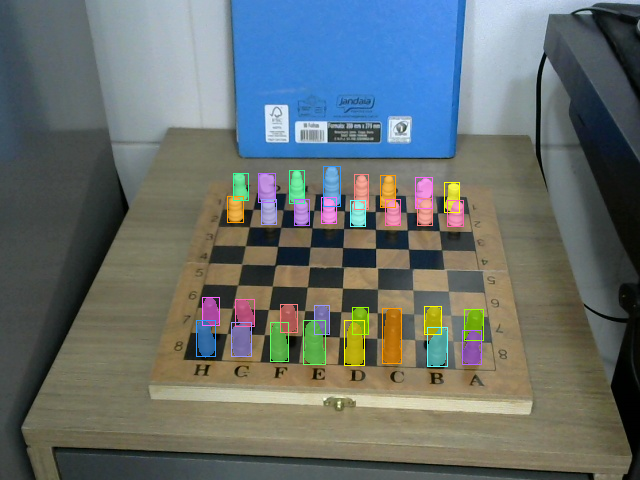

In [6]:
IMAGE_PATH = "../assets/sample_board.jpg"
PROMPT = "chess pieces"

image = Image.open(IMAGE_PATH).convert("RGB")
inference_state = processor.set_image(image)
inference_state = processor.set_text_prompt(state=inference_state, prompt=PROMPT)

detections = from_sam(sam_result=inference_state)
detections = detections[detections.confidence > 0.45]
print(f"There are {len(detections)} {PROMPT} objects detected in the image.\n")
annotate(image, detections, label=None)

In [7]:
detections.mask.shape

(31, 480, 640)

In [8]:
detections.xyxy.shape

(31, 4)

In [9]:
detections[[1,2]]

Detections(xyxy=array([[227.7929 , 196.1317 , 243.13736, 222.35748],
       [354.9856 , 174.94104, 368.61792, 209.48212]], dtype=float32), mask=array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]]), confidence=array([0.6710715, 0.6282884], dtype=float32), class_id=None, tracker_id=None, data={}, metadata={})

In [10]:
detections.xyxy.tolist()

[[444.93072509765625, 182.78225708007812, 459.96826171875, 212.03469848632812],
 [227.7928924560547,
  196.13169860839844,
  243.13735961914062,
  222.35748291015625],
 [354.985595703125, 174.9410400390625, 368.617919921875, 209.48211669921875],
 [447.7364807128906, 200.0666961669922, 463.82373046875, 226.7909393310547],
 [202.35243225097656,
  297.8605651855469,
  219.79417419433594,
  325.2914733886719],
 [258.733154296875, 173.05172729492188, 275.48956298828125, 202.4879608154297],
 [314.3329772949219,
  305.69696044921875,
  329.78570556640625,
  334.87384033203125],
 [196.90780639648438,
  320.36505126953125,
  215.39410400390625,
  356.7183532714844],
 [427.04876708984375,
  327.0556945800781,
  447.50201416015625,
  366.0064697265625],
 [233.47543334960938, 173.406494140625, 248.06527709960938, 200.484619140625],
 [270.1769104003906, 322.7072448730469, 288.5983581542969, 361.62481689453125],
 [464.8612976074219, 309.3532409667969, 483.34014892578125, 340.0694580078125],
 [344.29

In [16]:
centers = [[403.993408203125, 573.881591796875], [487.593017578125, 575.1414184570312], [571.5674438476562, 576.4068603515625], [655.919189453125, 577.6780395507812], [740.6507568359375, 578.9549560546875], [825.764892578125, 580.2376708984375], [911.2639770507812, 581.526123046875], [997.1507568359375, 582.8204956054688], [411.1369323730469, 506.2581787109375], [492.34942626953125, 507.3348388671875], [573.9154052734375, 508.41619873046875], [655.83740234375, 509.50225830078125], [738.1176147460938, 510.59307861328125], [820.7584228515625, 511.688720703125], [903.7622680664062, 512.7891845703125], [987.1314697265625, 513.8944702148438], [417.8821716308594, 442.4060363769531], [496.8399963378906, 443.3177185058594], [576.1320190429688, 444.2333068847656], [655.76025390625, 445.15277099609375], [735.7269287109375, 446.0761413574219], [816.0343017578125, 447.00341796875], [896.684326171875, 447.9346618652344], [977.6793212890625, 448.86993408203125], [424.26153564453125, 382.0181579589844], [501.0865478515625, 382.781005859375], [578.2279052734375, 383.54693603515625], [655.6875, 384.31610107421875], [733.46728515625, 385.08843994140625], [811.5691528320312, 385.86395263671875], [889.9953002929688, 386.6427001953125], [968.7476806640625, 387.4246826171875], [430.3039855957031, 324.82000732421875], [505.10845947265625, 325.4482421875], [580.2127075195312, 326.0789794921875], [655.6185302734375, 326.7122802734375], [731.3277587890625, 327.34808349609375], [807.3423461914062, 327.9864807128906], [883.6639404296875, 328.62744140625], [960.2944946289062, 329.2710266113281], [436.0355224609375, 270.56536865234375], [508.9229736328125, 271.0716552734375], [582.094970703125, 271.57989501953125], [655.55322265625, 272.0901794433594], [729.2994384765625, 272.6024169921875], [803.3351440429688, 273.11669921875], [877.6622314453125, 273.6330261230469], [952.2823486328125, 274.1513671875], [441.47955322265625, 219.0325927734375], [512.5458374023438, 219.42825317382812], [583.8825073242188, 219.825439453125], [655.4912719726562, 220.22412109375], [727.37353515625, 220.6243438720703], [799.531005859375, 221.02609252929688], [871.9652099609375, 221.4293670654297], [944.6776733398438, 221.83419799804688], [446.6571960449219, 170.02194213867188], [515.9910888671875, 170.3170623779297], [585.582275390625, 170.61329650878906], [655.432373046875, 170.91061401367188], [725.5427856445312, 171.2090606689453], [795.9148559570312, 171.5086212158203], [866.5501708984375, 171.80931091308594], [937.4501342773438, 172.1111297607422]]

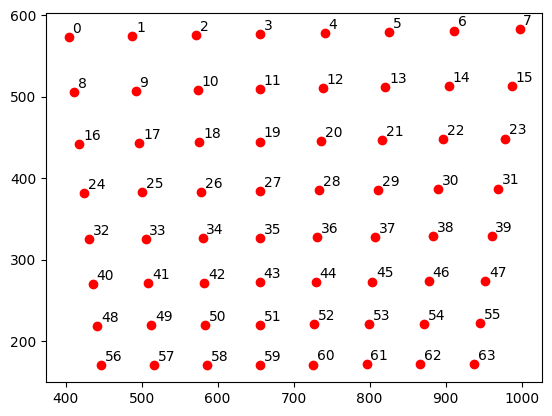

In [17]:
from matplotlib import pyplot as plt

for n, (x, y) in enumerate(centers):
    plt.plot(x, y, 'ro') 
    plt.text(x + 5, y + 5, str(n), color='black')   